


##Quick snapshots of top business news




In [ ]:
!pip install langgraph -q
!pip install langchain-openai -q
!pip install langchain-core -q
!pip install pydantic -q
!pip install python-dotenv -q
!pip install newsapi-python -q
!pip install beautifulsoup4 -q
!pip install ipython -q
!pip install nest_asyncio -q

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from datetime import datetime
import re

from getpass import getpass
from dotenv import load_dotenv

from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup

from IPython.display import display, Image as IPImage
import asyncio

In [ ]:
os.environ["NEWSAPI_KEY"] = 'YOUR API KEY'
os.environ["OPENAI_API_KEY"] = 'YOUR API KEY'

In [ ]:
model = "gpt-4o-mini"
llm = ChatOpenAI(model=model,)

##Define Data Structures

In [ ]:
class GraphState(TypedDict):
    news_query: Annotated[str, "Input query to extract news search parameters from."]
    num_searches_remaining: Annotated[int, "Number of articles to search for."]
    newsapi_params: Annotated[dict, "Structured argument for the News API."]
    past_searches: Annotated[List[dict], "List of search params already used."]
    articles_metadata: Annotated[list[dict], "Article metadata response from the News API"]
    scraped_urls: Annotated[List[str], "List of urls already scraped."]
    num_articles_tldr: Annotated[int, "Number of articles to create TL;DR for."]
    potential_articles: Annotated[List[dict[str, str, str]], "Article with full text to consider summarizing."]
    tldr_articles: Annotated[List[dict[str, str, str]], "Selected article TL;DRs."]
    formatted_results: Annotated[str, "Formatted results to display."]

In [ ]:
from pydantic import model_validator, ValidationError

class NewsApiParams(BaseModel):
    q: str = Field(description="1-3 concise keyword search terms that are not too specific")
    category: str = Field(
        default="business",
        description="The category you want to get headlines for. Possible options: 'business', 'entertainment', 'general', 'health', 'science', 'sports', 'technology'"
    )
    language: str = Field(
        description="Language of articles, defaults to 'en'. Possible options: ['ar', 'de', 'en', 'es', 'fr', 'he', 'it', 'nl', 'no', 'pt', 'ru', 'se', 'ud', 'zh']",
        default="en"
    )

    @model_validator(mode="after")
    def validate_category(cls, values):
        if values.category != 'business':
            raise ValueError("Category must be 'business'.")
        return values

##Define LangGraph Functions

In [ ]:
def api_params(state: GraphState) -> GraphState:
    """Based on the query, generate News API params."""
    # initialize parser to define the structure of the response
    parser = JsonOutputParser(pydantic_object=NewsApiParams)

    # retrieve today's date
    today_date = datetime.now().strftime("%Y-%m-%d")

    # retrieve list of past search params
    past_searches = state["past_searches"]

    # retrieve number of searches remaining
    num_searches_remaining = state["num_searches_remaining"]

    # retrieve the user's query
    news_query = state["news_query"]

    template = """
    Today is {today_date}.

    Create a param dict for the News API based on the user query:
    {query}

    These searches have already been made. Loosen the search terms to get more results.
    {past_searches}

    Following these formatting instructions:
    {format_instructions}

    Including this one, you have {num_searches_remaining} searches remaining.
    If this is your last search, use all news sources and a 30 days search range.
    """

    # create a prompt template to merge the query, today's date, and the format instructions
    prompt_template = PromptTemplate(
        template=template,
        variables={"today": today_date, "query": news_query, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining},
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    # create prompt chain template
    chain = prompt_template | llm | parser

    # invoke the chain with the news api query
    result = chain.invoke({"query": news_query, "today_date": today_date, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining})

    #Enforce to business
    result['category'] = 'business'

    # update the state

    state["newsapi_params"] = result

    return state

In [ ]:
def ret_metadata(state: GraphState) -> GraphState:
    """Using the NewsAPI params, perform api call."""
    # parameters generated for the News API
    newsapi_params = state["newsapi_params"]

    # decrement the number of searches remaining
    state['num_searches_remaining'] -= 1

    try:
        # create a NewsApiClient object
        newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))

        # retreive the metadata of the top articles
        articles = newsapi.get_top_headlines(**newsapi_params)

        # append this search term to the past searches to avoid duplicates
        state['past_searches'].append(newsapi_params)

        # load urls that have already been returned and scraped
        scraped_urls = state["scraped_urls"]

        # filter out articles that have already been scraped
        new_articles = []
        for article in articles['articles']:
            if article['url'] not in scraped_urls and len(state['potential_articles']) + len(new_articles) < 10:
                new_articles.append(article)

        # reassign new articles to the state
        state["articles_metadata"] = new_articles

    # handle exceptions
    except Exception as e:
        print(f"Error: {e}")

    return state

In [ ]:
def ret_content(state: GraphState) -> GraphState:
    """Web scrapes to retrieve article text."""
    # load retrieved article metadata
    articles_metadata = state["articles_metadata"]
    # Add headers to simulate a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
    }

    # create list to store valid article dicts
    potential_articles = []

    # iterate over the urls
    for article in articles_metadata:
        # extract the url
        url = article['url']

        # use beautiful soup to extract the article content
        response = requests.get(url, headers=headers)

        # check if the request was successful
        if response.status_code == 200:
            # parse the HTML content
            soup = BeautifulSoup(response.content, 'html.parser')

            # find the article content
            text = soup.get_text(strip=True)

            # append article dict to list
            potential_articles.append({"title": article["title"], "url": url, "description": article["description"], "text": text})

            # append the url to the processed urls
            state["scraped_urls"].append(url)

    # append the processed articles to the state
    state["potential_articles"].extend(potential_articles)

    return state

In [ ]:
def top_urls(state: GraphState) -> GraphState:
    """Based on the article synoses, choose the top-n articles to summarize."""
    news_query = state["news_query"]
    num_articles_tldr = state["num_articles_tldr"]

    # load all processed articles with full text but no summaries
    potential_articles = state["potential_articles"]

    # format the metadata
    formatted_metadata = "\n".join([f"{article['url']}\n{article['description']}\n" for article in potential_articles])

    prompt = f"""
    Based on the user news query:
    {news_query}

    Reply with a list of strings of up to {num_articles_tldr} relevant urls.
    Don't add any urls that are not relevant or aren't listed specifically.
    {formatted_metadata}
    """
    result = llm.invoke(prompt).content

    # use regex to extract the urls as a list
    url_pattern = r'(https?://[^\s",]+)'

    # Find all URLs in the text
    urls = re.findall(url_pattern, result)

    # add the selected article metadata to the state
    tldr_articles = [article for article in potential_articles if article['url'] in urls]

    # tldr_articles = [article for article in potential_articles if article['url'] in urls]
    state["tldr_articles"] = tldr_articles

    return state

In [ ]:
async def async_summarise(state: GraphState) -> GraphState:
    """Summarize the articles based on full text."""
    tldr_articles = state["tldr_articles"]

    # prompt = """
    # Summarize the article text in a bulleted tl;dr. Each line should start with a hyphen -
    # {article_text}
    # """

    prompt = """
    Create a * bulleted summarizing tldr for the article:
    {text}

    Be sure to follow the following format exaxtly with nothing else:
    {title}
    {url}
    * tl;dr bulleted summary
    * use bullet points for each sentence
    """

    # iterate over the selected articles and collect summaries synchronously
    for i in range(len(tldr_articles)):
        text = tldr_articles[i]["text"]
        title = tldr_articles[i]["title"]
        url = tldr_articles[i]["url"]
        # invoke the llm synchronously
        result = llm.invoke(prompt.format(title=title, url=url, text=text))
        tldr_articles[i]["summary"] = result.content

    state["tldr_articles"] = tldr_articles

    return state

In [ ]:
def format_output(state: GraphState) -> GraphState:
    """Format the results for display."""
    # load a list of past search queries
    q = [newsapi_params["q"] for newsapi_params in state["past_searches"]]
    formatted_results = f"Here are the top {len(state['tldr_articles'])} articles based on search terms:\n{', '.join(q)}\n\n"

    # load the summarized articles
    tldr_articles = state["tldr_articles"]

    # format article tl;dr summaries
    tldr_articles = "\n\n".join([f"{article['summary']}" for article in tldr_articles])

    # concatenate summaries to the formatted results
    formatted_results += tldr_articles

    state["formatted_results"] = formatted_results

    return state

## Setup LangGraph Workflow

In [ ]:
def article_decision(state: GraphState) -> str:
    """Check results of ret_content to determine next step."""
    if state["num_searches_remaining"] == 0:
        # if no articles with text were found return END
        if len(state["potential_articles"]) == 0:
            state["formatted_results"] = "No articles with text found."
            return "END"
        # if some articles were found, move on to selecting the top urls
        else:
            return "top_urls"
    else:
        # if the number of articles found is less than the number of articles to summarize, continue searching
        if len(state["potential_articles"]) < state["num_articles_tldr"]:
            return "api_params"
        # otherwise move on to selecting the top urls
        else:
            return "top_urls"

In [ ]:
workflow = Graph()

workflow.set_entry_point("api_params")

workflow.add_node("api_params", api_params)
workflow.add_node("ret_metadata", ret_metadata)
workflow.add_node("ret_content", ret_content)
workflow.add_node("top_urls", top_urls)
workflow.add_node("async_summarise", async_summarise)
workflow.add_node("format_output", format_output)
# workflow.add_node("add_commentary", add_commentary)

workflow.add_edge("api_params", "ret_metadata")
workflow.add_edge("ret_metadata", "ret_content")
# # if the number of articles with parseable text is less than number requested, then search for more articles
workflow.add_conditional_edges(
    "ret_content",
    article_decision,
    {
        "api_params": "api_params",
        "top_urls": "top_urls",
        "END": END
    }
    )
workflow.add_edge("top_urls", "async_summarise")
workflow.add_conditional_edges(
    "async_summarise",
    lambda state: "format_output" if len(state["tldr_articles"]) > 0 else "END",
    {
        "format_output": "format_output",
        "END": END
    }
    )
workflow.add_edge("format_output", END)

app = workflow.compile()

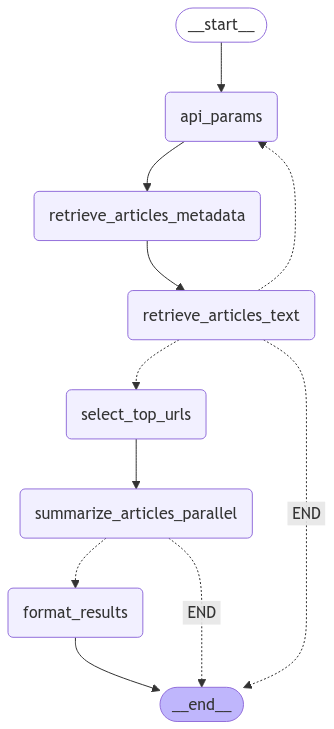

In [ ]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

##Run Workflow Function

In [ ]:
async def run_workflow(query: str, num_searches_remaining: int = 7, num_articles_tldr: int = 5):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "news_query": query,
        "num_searches_remaining": num_searches_remaining,
        "newsapi_params": {},
        "past_searches": [],
        "articles_metadata": [],
        "scraped_urls": [],
        "num_articles_tldr": num_articles_tldr,
        "potential_articles": [],
        "tldr_articles": [],
        "formatted_results": "No articles with text found."
    }
    try:
        result = await app.ainvoke(initial_state)

        return result["formatted_results"]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


Execute Workflow

In [ ]:
query = "ai"
print(await run_workflow(query, num_articles_tldr=3))

Here are the top 3 articles based on search terms:
artificial intelligence, AI

Google can turn your Discover feed into an AI-generated podcast - The Verge  
https://www.theverge.com/2025/1/9/24339765/google-labs-daily-listen-ai-generated-podcast-overviews  
* Google is testing a feature called Daily Listen that creates personalized podcasts from user search and Discover feed history.  
* The feature is available to Android and iOS users in the US through Google's Search Labs.  
* Daily Listen summarizes selected news articles into a roughly five-minute audio overview.  
* Users can access a text transcript and control audio playback with options to play, pause, mute, rewind, or skip.  
* A “Related stories” tab allows users to interact with content and explore new topics.  
* The feature is currently experimental, with no confirmation on wider public rollout.  
* Previous AI features from Google have transitioned from testing to public availability, suggesting Daily Listen may do the 